In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digikala-color-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1175549%2F1968503%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T231549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37984f2f70b54637a08b934f6066a88d3580557aa6668ea43c4e93c36b326c5a7a20e81ac72741268246eaa3cc44ca455006859c86da49d2fe18c5024a531ab8793aa756a2a031e39d280f9ba092ddcdbf4e38ce749aed787b8ce1296884a01f347f59c1bfb12248f1dcce3939184972d8f1a22ba1a42945d8525c1f7c0e6406e8bb7e4e557fa0375efe62e0a326e4413c033fb3361df69dfd637dfa3831f3162b7f52bd6e5a547382b7bb4fbdaa3bbc2c99d69dadc6ad2fdd0b34e1e9054c03e55e65445fe8391a1e590067e3b2421b0fc9a9b75cbda365315553da79ba2c0f179e05bab1cbc9369c7ad04515c28e03ba9b1668f245cd7dbc2a6719f76f53b6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 37633424 bytes downloaded
Downloaded and uncompressed: digikala-color-classification
Data source import complete.


In [ ]:
!pip install torchsummary

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image

In [ ]:
import os

data_dir = '/kaggle/input/digikala-color-classification/train'
colors = os.listdir(data_dir)
print(colors)


['red', 'white', 'purple', 'pink', 'blue', 'orange', 'black', 'silver', 'brown', 'green', 'yellow', 'grey']


In [ ]:
num_labels = len(colors)

color_to_label = {
    color: idx for idx, color in enumerate(colors)
}

label_to_color = {
    idx: color for idx, color in enumerate(colors)
}

print(num_labels)
print(color_to_label)
print(label_to_color)

12
{'red': 0, 'white': 1, 'purple': 2, 'pink': 3, 'blue': 4, 'orange': 5, 'black': 6, 'silver': 7, 'brown': 8, 'green': 9, 'yellow': 10, 'grey': 11}
{0: 'red', 1: 'white', 2: 'purple', 3: 'pink', 4: 'blue', 5: 'orange', 6: 'black', 7: 'silver', 8: 'brown', 9: 'green', 10: 'yellow', 11: 'grey'}


In [ ]:
def random_pick() -> tuple[np.ndarray, int]:
    color = random.choice(colors)
    img_fnames = os.listdir(f'{data_dir}/{color}')
    img_path = f'{data_dir}/{color}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = color_to_label[color]
    return img, label

image_shape=(224, 224, 3)


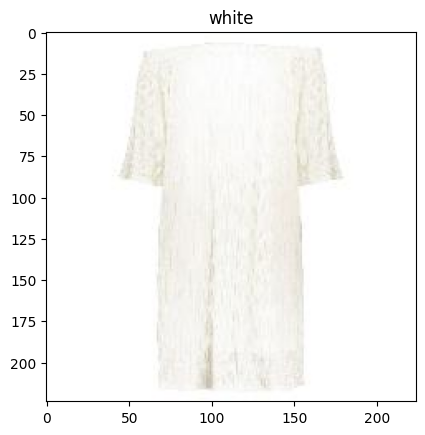

In [ ]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_color[label])
plt.show()

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from torchvision import transforms

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def load(self, img_path):
        img = Image.open(img_path).convert('RGB')
        t_img = self.transform(img)
        return t_img

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class ImageDataset(Dataset):

    data_dir = '/kaggle/input/digikala-color-classification/train'

    def __init__(self, image_loader):
        colors = os.listdir(self.data_dir)

        self.data = []
        for color in tqdm(colors):
            image_fnames = [i for i in os.listdir(f'{self.data_dir}/{color}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.data_dir}/{color}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = color_to_label[color]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


In [ ]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [ ]:
val_ratio = 0.1
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 5586, val: 623, test: 30


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

### CNN feature map size
$F = floor(\frac{(I - K) + 2P}{S} + 1)$

In [ ]:
class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ColorClassifier().to(device)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy = corrects / total

    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()

    val_loss /= len(data_loader)
    val_accuracy = corrects / total

    return val_loss, val_accuracy

In [ ]:
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 88/88 [01:57<00:00,  1.33s/it]


epoch=1, train_loss=1.988, val_loss=1.626, train_accuracy=0.315, val_accuracy=0.496


100%|██████████| 88/88 [01:53<00:00,  1.30s/it]


epoch=2, train_loss=1.489, val_loss=1.175, train_accuracy=0.498, val_accuracy=0.626


100%|██████████| 88/88 [01:52<00:00,  1.28s/it]


epoch=3, train_loss=1.283, val_loss=1.069, train_accuracy=0.569, val_accuracy=0.673


100%|██████████| 88/88 [01:52<00:00,  1.28s/it]


epoch=4, train_loss=1.190, val_loss=0.998, train_accuracy=0.603, val_accuracy=0.682


100%|██████████| 88/88 [01:52<00:00,  1.28s/it]


epoch=5, train_loss=1.137, val_loss=0.935, train_accuracy=0.626, val_accuracy=0.671


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=6, train_loss=1.118, val_loss=0.928, train_accuracy=0.637, val_accuracy=0.708


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=7, train_loss=1.087, val_loss=0.940, train_accuracy=0.641, val_accuracy=0.705


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=8, train_loss=1.069, val_loss=0.881, train_accuracy=0.648, val_accuracy=0.719


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=9, train_loss=1.023, val_loss=0.849, train_accuracy=0.665, val_accuracy=0.713


100%|██████████| 88/88 [01:53<00:00,  1.29s/it]


epoch=10, train_loss=1.028, val_loss=0.853, train_accuracy=0.663, val_accuracy=0.737


100%|██████████| 88/88 [01:59<00:00,  1.35s/it]


epoch=11, train_loss=0.987, val_loss=0.898, train_accuracy=0.668, val_accuracy=0.703


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=12, train_loss=0.982, val_loss=0.830, train_accuracy=0.675, val_accuracy=0.754


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=13, train_loss=0.994, val_loss=0.819, train_accuracy=0.674, val_accuracy=0.751


100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


epoch=14, train_loss=0.948, val_loss=0.828, train_accuracy=0.684, val_accuracy=0.738


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=15, train_loss=0.942, val_loss=0.788, train_accuracy=0.693, val_accuracy=0.742


100%|██████████| 88/88 [02:00<00:00,  1.37s/it]


epoch=16, train_loss=0.929, val_loss=0.823, train_accuracy=0.699, val_accuracy=0.722


100%|██████████| 88/88 [01:55<00:00,  1.32s/it]


epoch=17, train_loss=0.916, val_loss=0.824, train_accuracy=0.699, val_accuracy=0.745


100%|██████████| 88/88 [01:56<00:00,  1.33s/it]


epoch=18, train_loss=0.906, val_loss=0.868, train_accuracy=0.696, val_accuracy=0.714


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=19, train_loss=0.883, val_loss=0.792, train_accuracy=0.704, val_accuracy=0.735


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=20, train_loss=0.903, val_loss=0.793, train_accuracy=0.703, val_accuracy=0.748


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=21, train_loss=0.870, val_loss=0.777, train_accuracy=0.708, val_accuracy=0.759


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=22, train_loss=0.856, val_loss=0.806, train_accuracy=0.713, val_accuracy=0.745


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=23, train_loss=0.827, val_loss=0.773, train_accuracy=0.723, val_accuracy=0.759


100%|██████████| 88/88 [01:55<00:00,  1.32s/it]


epoch=24, train_loss=0.838, val_loss=0.779, train_accuracy=0.724, val_accuracy=0.762


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=25, train_loss=0.835, val_loss=0.832, train_accuracy=0.718, val_accuracy=0.735


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=26, train_loss=0.806, val_loss=0.835, train_accuracy=0.737, val_accuracy=0.734


100%|██████████| 88/88 [01:55<00:00,  1.32s/it]


epoch=27, train_loss=0.813, val_loss=0.794, train_accuracy=0.728, val_accuracy=0.750


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=28, train_loss=0.825, val_loss=0.852, train_accuracy=0.728, val_accuracy=0.729


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=29, train_loss=0.787, val_loss=0.775, train_accuracy=0.741, val_accuracy=0.750


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=30, train_loss=0.781, val_loss=0.773, train_accuracy=0.738, val_accuracy=0.754


100%|██████████| 88/88 [02:20<00:00,  1.60s/it]


epoch=31, train_loss=0.772, val_loss=0.796, train_accuracy=0.744, val_accuracy=0.732


100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


epoch=32, train_loss=0.769, val_loss=0.745, train_accuracy=0.747, val_accuracy=0.753


100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


epoch=33, train_loss=0.760, val_loss=0.812, train_accuracy=0.744, val_accuracy=0.750


100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


epoch=34, train_loss=0.756, val_loss=0.789, train_accuracy=0.752, val_accuracy=0.761


100%|██████████| 88/88 [02:19<00:00,  1.58s/it]


epoch=35, train_loss=0.762, val_loss=0.760, train_accuracy=0.752, val_accuracy=0.758


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


epoch=36, train_loss=0.760, val_loss=0.759, train_accuracy=0.747, val_accuracy=0.762


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=37, train_loss=0.737, val_loss=0.771, train_accuracy=0.751, val_accuracy=0.761


100%|██████████| 88/88 [01:55<00:00,  1.32s/it]


epoch=38, train_loss=0.715, val_loss=0.766, train_accuracy=0.758, val_accuracy=0.766


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=39, train_loss=0.712, val_loss=0.736, train_accuracy=0.763, val_accuracy=0.766


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=40, train_loss=0.713, val_loss=0.793, train_accuracy=0.759, val_accuracy=0.754


100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


epoch=41, train_loss=0.729, val_loss=0.802, train_accuracy=0.759, val_accuracy=0.759


100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


epoch=42, train_loss=0.690, val_loss=0.766, train_accuracy=0.768, val_accuracy=0.761


100%|██████████| 88/88 [01:54<00:00,  1.31s/it]


epoch=43, train_loss=0.709, val_loss=0.768, train_accuracy=0.766, val_accuracy=0.764


100%|██████████| 88/88 [01:55<00:00,  1.32s/it]


epoch=44, train_loss=0.699, val_loss=0.771, train_accuracy=0.762, val_accuracy=0.754


100%|██████████| 88/88 [01:58<00:00,  1.35s/it]


epoch=45, train_loss=0.680, val_loss=0.812, train_accuracy=0.771, val_accuracy=0.753


100%|██████████| 88/88 [02:00<00:00,  1.36s/it]


epoch=46, train_loss=0.679, val_loss=0.767, train_accuracy=0.773, val_accuracy=0.766


100%|██████████| 88/88 [02:02<00:00,  1.39s/it]


epoch=47, train_loss=0.698, val_loss=0.787, train_accuracy=0.765, val_accuracy=0.762


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


epoch=48, train_loss=0.667, val_loss=0.794, train_accuracy=0.779, val_accuracy=0.761


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


epoch=49, train_loss=0.674, val_loss=0.738, train_accuracy=0.774, val_accuracy=0.769


100%|██████████| 88/88 [01:57<00:00,  1.33s/it]


epoch=50, train_loss=0.656, val_loss=0.792, train_accuracy=0.779, val_accuracy=0.767


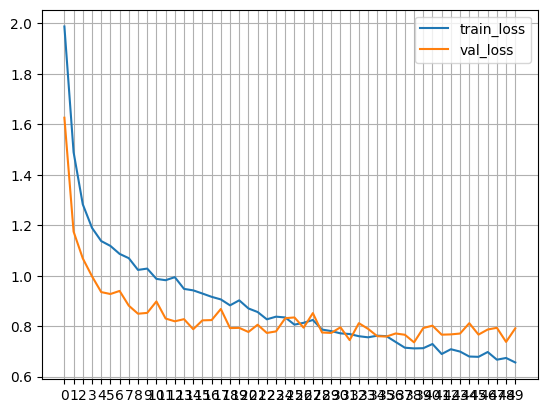

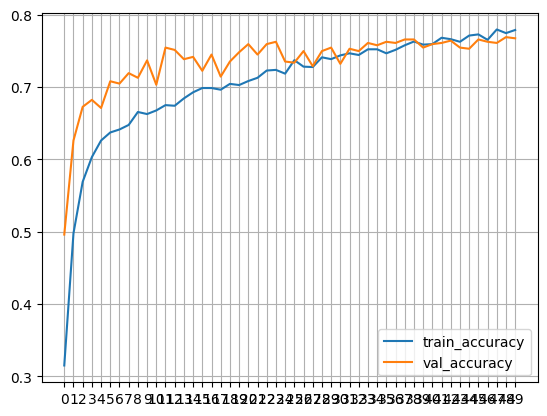

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)
plt.legend(['train_loss', 'val_loss'])
plt.xticks(range(epochs))
plt.grid(True)
plt.show()

plt.plot(range(epochs), train_accuracies)
plt.plot(range(epochs), val_accuracies)
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xticks(range(epochs))
plt.grid(True)
plt.show()

In [ ]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(30))
sample_loader = DataLoader(sample_data, batch_size=30)

In [ ]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])

        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'true: {label_to_color[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f'{label_to_color[best_idx0]}: {outputs[i, best_idx0]:.3f}\n'
        title += f'{label_to_color[best_idx1]}: {outputs[i, best_idx1]:.3f}\n'
        axes[i // 5, i % 5].set_title(title)

    plt.show()

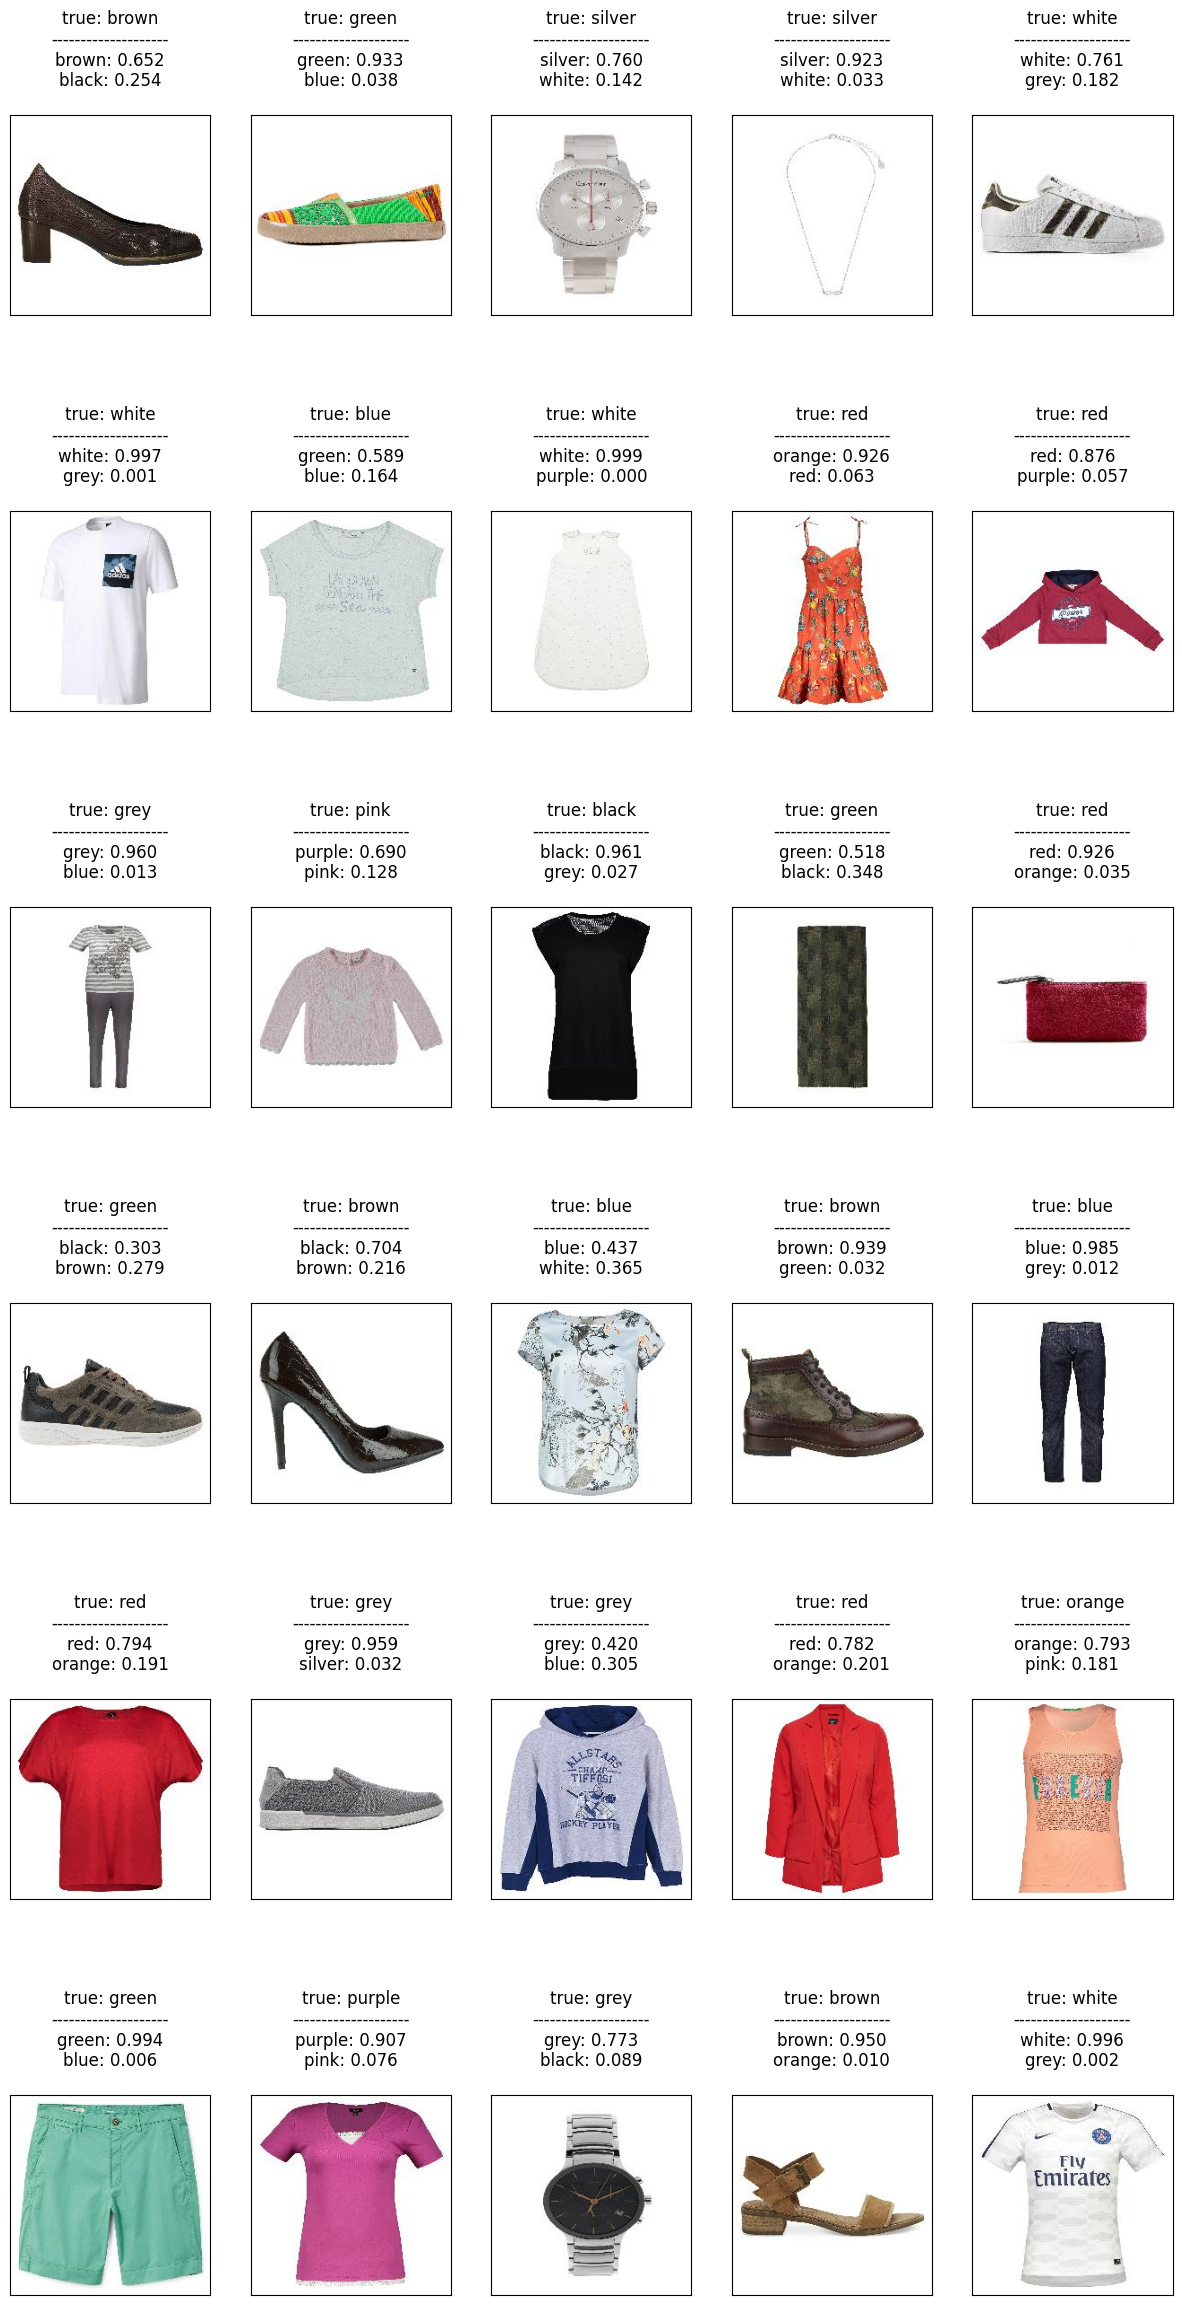

In [ ]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)

In [ ]:
# Misalkan Anda telah melatih model dan ingin menyimpannya
# Simpan state_dict dari model
torch.save(model.state_dict(), 'color_classifier.pth')
